In [18]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
import scipy.stats
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
from scipy import sparse, stats, spatial
import scipy.sparse.linalg

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

In [2]:
N = 10

train_audio_path = '../Project/data/train/audio'
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()

paths = []

for direct in dirs:
    if not direct.startswith('_background_noise_'):
        waves = (list(np.random.choice([train_audio_path + '/' + direct + '/' + f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')],N)))
        paths.extend(waves) 

In [3]:
N_MFCC = 20

def compute_mfcc(filepath):
    audio, sampling_rate = librosa.load(filepath, sr=None, mono=True)
    return librosa.feature.mfcc(y=audio,sr=sampling_rate)

In [20]:
stat_name= ['mean','std','skew','kurtosis','median']
col_names = [('mfcc',stat_name[i],j) for i in range(len(stat_name))  for j in range(N_MFCC)]
features_og = pd.DataFrame(columns=pd.MultiIndex.from_tuples(col_names))

for file in paths:
    mfcc = compute_mfcc(file)
    features_og.at[file, ('mfcc', 'mean')] = np.mean(mfcc,axis=1)
    features_og.at[file, ('mfcc', 'std')] = np.std(mfcc,axis=1)
    features_og.at[file, ('mfcc', 'skew')] = scipy.stats.skew(mfcc,axis=1)
    features_og.at[file, ('mfcc', 'kurtosis')] = scipy.stats.kurtosis(mfcc,axis=1)
    features_og.at[file, ('mfcc', 'median')] = np.median(mfcc,axis=1)

features_og

C:\Users\Kiran\Anaconda3\envs\NTDS\lib\site-packages\ipykernel\zmqshell.py:533: PerformanceWarning:

indexing past lexsort depth may impact performance.

C:\Users\Kiran\Anaconda3\envs\NTDS\lib\site-packages\IPython\core\interactiveshell.py:2850: PerformanceWarning:

indexing past lexsort depth may impact performance.



mfcc           \
                                                       mean            
                                                         0        1    
../Project/data/train/audio/bed/ea9f8e11_nohash... -303.794  140.738   
../Project/data/train/audio/bed/7fa5fa1f_nohash...  -300.44  98.9082   
../Project/data/train/audio/bed/62ef962d_nohash... -306.099  56.8137   
../Project/data/train/audio/bed/e41a903b_nohash... -447.522  85.0699   
../Project/data/train/audio/bed/afb9e62e_nohash... -346.886  83.5788   
../Project/data/train/audio/bed/cb2929ce_nohash... -545.691  92.1132   
../Project/data/train/audio/bed/5a0bc987_nohash... -440.125  79.1832   
../Project/data/train/audio/bed/f9273a21_nohash... -459.272  114.557   
../Project/data/train/audio/bed/099d52ad_nohash... -446.936  71.4973   
../Project/data/train/audio/bed/079dfce3_nohash... -330.592  66.9458   
../Project/data/train/audio/bird/bc065a17_nohas... -500.037  101.895   
../Project/data/train/audio/bird/a902ce9b_nohas... -289.937  76.2575   
../Project/data/train/audio/bird/6a27a9bf_nohas... -410.765  79.5341   
../Project/data/train/audio/bird/3ca784ec_nohas... -340.208  120.046   
../Project/data/train/audio/bird/11099149_nohas... -437.204  105.325   
../Project/data/train/audio/bird/540d8427_nohas... -95.4431  88.7527   
../Project/data/train/audio/bird/b15fc37d_nohas... -359.166  74.4935   
../Project/data/train/audio/bird/c948d727_nohas... -175.091  160.955   
../Project/data/train/audio/bird/73cccfaf_nohas... -446.149  80.0866   
../Project/data/train/audio/bird/541120c7_nohas... -312.011  93.7489   
../Project/data/train/audio/cat/24ad3ebe_nohash... -404.438 -3.34414   
../Project/data/train/audio/cat/3824c00e_nohash...  -414.96  56.7513   
../Project/data/train/audio/cat/a3fc7884_nohash... -519.153  28.4261   
../Project/data/train/audio/cat/b3849d6e_nohash...  -248.89   62.032   
../Project/data/train/audio/cat/ab5d7179_nohash... -266.726    75.84   
../Project/data/train/audio/cat/cd3331a6_nohash...  -243.73  96.5138   
../Project/data/train/audio/cat/7bf801d1_nohash...   -280.5  47.7157   
../Project/data/train/audio/cat/b06c19b0_nohash... -276.953  59.7471   
../Project/data/train/audio/cat/4abb2400_nohash...  -305.96   62.188   
../Project/data/train/audio/cat/840c366d_nohash... -332.714  86.2674   
...                                                     ...      ...   
../Project/data/train/audio/wow/422d3197_nohash... -314.232  80.0811   
../Project/data/train/audio/wow/4a0e2c16_nohash... -505.649  94.2132   
../Project/data/train/audio/wow/365531e2_nohash... -392.291  139.587   
../Project/data/train/audio/wow/b7669804_nohash... -606.303   76.827   
../Project/data/train/audio/wow/11321027_nohash... -319.007  99.4823   
../Project/data/train/audio/wow/5744b6a7_nohash... -344.778  108.831   
../Project/data/train/audio/wow/1993db46_nohash... -510.627  91.3564   
../Project/data/train/audio/wow/baeac2ba_nohash... -414.527  117.913   
../Project/data/train/audio/wow/92a9c5e6_nohash...   -293.6   123.72   
../Project/data/train/audio/wow/36050ef3_nohash... -503.148  100.335   
../Project/data/train/audio/yes/1aeef15e_nohash... -443.829  82.8627   
../Project/data/train/audio/yes/aeb99b1c_nohash... -584.196  104.218   
../Project/data/train/audio/yes/6cb6eee7_nohash... -233.067  53.8465   
../Project/data/train/audio/yes/28460a60_nohash... -236.546   45.731   
../Project/data/train/audio/yes/c120e80e_nohash... -411.816  34.5848   
../Project/data/train/audio/yes/db79a764_nohash... -498.347  34.3188   
../Project/data/train/audio/yes/e8e960fd_nohash... -225.353  34.2359   
../Project/data/train/audio/yes/8b39e36f_nohash... -555.483  92.5668   
../Project/data/train/audio/yes/90b0b91a_nohash...  -488.41  7.08574   
../Project/data/train/audio/yes/708a9569_nohash... -493.812  20.8924   
../Project/data/train/audio/zero/97101ef3_nohas... -459.118  109.481   
../Project/data/train/audio/zero/333784b7_nohas... -362.911  82.3413   
../Project/data/train/a

In [25]:
# drop features
features = pd.DataFrame(features_og)
features -= features.mean(axis=0)
features /= features.std(axis=0)

distances = spatial.distance.squareform(spatial.distance.pdist(features,'cosine'))

n=distances.shape[0]
kernel_width = distances.mean()
weights = np.exp(np.divide(-np.square(distances),kernel_width**2))
np.fill_diagonal(weights,0)

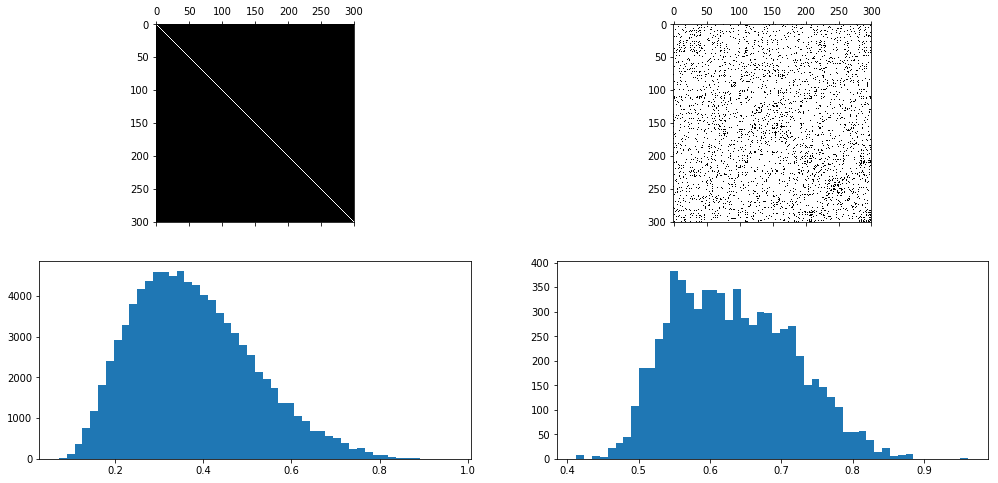

In [26]:
fix, axes = plt.subplots(2, 2, figsize=(17, 8))
def plot(weights, axes):
    axes[0].spy(weights)
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50);
plot(weights, axes[:, 0])

NEIGHBORS = 30

for i in range(weights.shape[0]):
    idx = weights[i,:].argsort()[:-NEIGHBORS]
    weights[i,idx] = 0
    weights[idx,i] = 0

plot(weights, axes[:, 1])
   

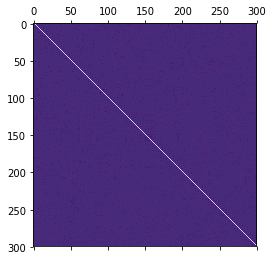

In [29]:
degrees = np.sum(weights,axis=0)
laplacian = np.diag(degrees**-0.5) @ (np.diag(degrees) - weights) @ np.diag(degrees**-0.5)
laplacian = sparse.csr_matrix(laplacian)
plt.matshow(laplacian.todense());

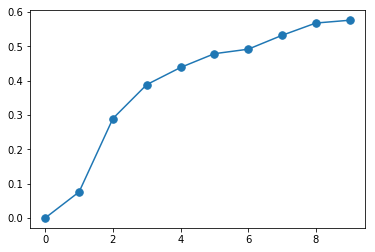

In [30]:
eigenvalues, eigenvectors = sparse.linalg.eigsh(A=laplacian,k=10,which='SM')

plt.plot(eigenvalues, '.-', markersize=15);

x = eigenvectors[:,1]
y = eigenvectors[:,2]

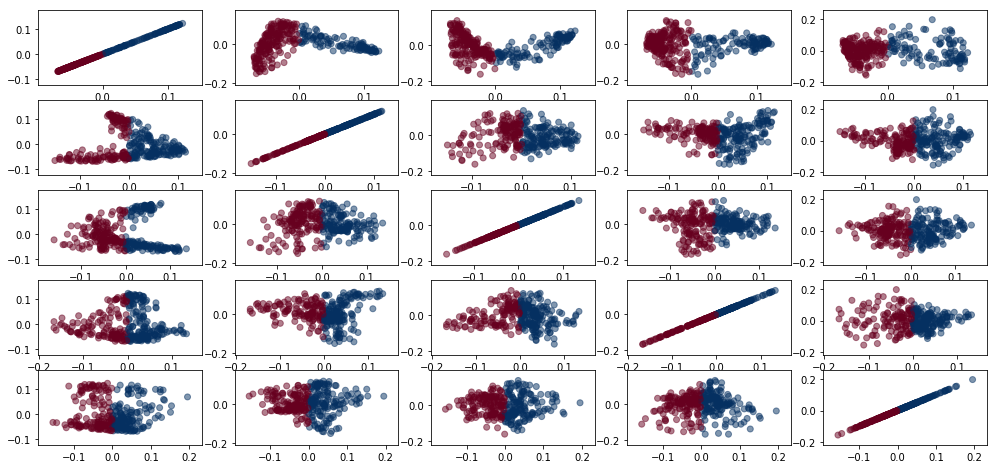

In [34]:
fix, axes = plt.subplots(5, 5, figsize=(17, 8))
for i in range(1,6):
    for j in range(1,6):
        x = eigenvectors[:,i]
        y = eigenvectors[:,j]
        labels = np.sign(x)
        axes[i-1,j-1].scatter(x, y, c=labels, cmap='RdBu', alpha=0.5)